# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load and Preprocess dataset

In [ ]:
df = pd.read_csv('Biotech_preprocessed_dataset_with_outliers.csv')
# df = pd.read_csv('Biotech_preprocessed_dataset_without_outliers.csv')
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = df['Time'].dt.date
df.set_index('Date', inplace=True)
df

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-01-04,2024-01-04 15:00:00,15:00:00,15,Thursday,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 16:00:00,16:00:00,16,Thursday,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 17:00:00,17:00:00,17,Thursday,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 18:00:00,18:00:00,18,Thursday,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 19:00:00,19:00:00,19,Thursday,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,2024-07-08 05:00:00,05:00:00,5,Monday,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 06:00:00,06:00:00,6,Monday,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 07:00:00,07:00:00,7,Monday,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False


In [ ]:
# Keep the rows belonging to Sping season only (March, april, and May)
start_date = pd.to_datetime('2024-03-01')
end_date = pd.to_datetime('2024-06-01')

df_spring = df[(df['Time'] >= start_date) & (df['Time'] < end_date)]
df_spring

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-01,2024-03-01 00:00:00,00:00:00,0,Friday,792.0,410.0,198.0,184.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 01:00:00,01:00:00,1,Friday,733.0,222.0,326.0,185.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 02:00:00,02:00:00,2,Friday,706.0,222.0,300.0,184.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 03:00:00,03:00:00,3,Friday,684.0,302.0,197.0,185.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 04:00:00,04:00:00,4,Friday,784.0,400.0,199.0,185.0,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,2024-05-31 19:00:00,19:00:00,19,Friday,1070.0,702.0,194.0,174.0,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 20:00:00,20:00:00,20,Friday,689.0,212.0,295.0,182.0,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 21:00:00,21:00:00,21,Friday,718.0,213.0,322.0,183.0,True,False,False,False,False,False,False,False


In [ ]:
df_spring.describe()

,Time,Hour,Total (W),Phase_A (W),Phase_B (W),Phase_C (W)
count,2208,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,2024-04-15 23:30:00,11.500000,1174.199728,643.772192,343.756341,186.619112
min,2024-03-01 00:00:00,0.000000,371.000000,76.000000,109.000000,92.000000
25%,2024-03-23 23:45:00,5.750000,757.750000,316.750000,210.000000,116.000000
50%,2024-04-15 23:30:00,11.500000,958.500000,455.000000,294.000000,183.000000
75%,2024-05-08 23:15:00,17.250000,1302.250000,780.250000,363.000000,186.000000
max,2024-05-31 23:00:00,23.000000,6818.000000,6390.000000,2248.000000,3682.000000
std,NaN,6.923755,792.425590,653.310162,233.842126,126.651852


In [ ]:
# df_holiday = df[df['Holiday'] == True]
df_holiday = df_spring[df_spring['Holiday'] == True]
df_holiday

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-02,2024-03-02 00:00:00,00:00:00,0,Saturday,755.0,187.0,384.0,184.0,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 01:00:00,01:00:00,1,Saturday,620.0,232.0,203.0,185.0,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 02:00:00,02:00:00,2,Saturday,800.0,307.0,309.0,184.0,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 03:00:00,03:00:00,3,Saturday,801.0,418.0,199.0,184.0,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 04:00:00,04:00:00,4,Saturday,710.0,330.0,196.0,184.0,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,2024-05-28 19:00:00,19:00:00,19,Tuesday,1368.0,902.0,284.0,182.0,False,False,False,False,False,True,False,True
2024-05-28,2024-05-28 20:00:00,20:00:00,20,Tuesday,1533.0,1051.0,299.0,183.0,False,False,False,False,False,True,False,True
2024-05-28,2024-05-28 21:00:00,21:00:00,21,Tuesday,899.0,395.0,321.0,183.0,False,False,False,False,False,True,False,True


In [ ]:
# df_office_day = df[df['Holiday'] == False]
df_office_day = df_spring[df_spring['Holiday'] == False]
df_office_day

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-01,2024-03-01 00:00:00,00:00:00,0,Friday,792.0,410.0,198.0,184.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 01:00:00,01:00:00,1,Friday,733.0,222.0,326.0,185.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 02:00:00,02:00:00,2,Friday,706.0,222.0,300.0,184.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 03:00:00,03:00:00,3,Friday,684.0,302.0,197.0,185.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 04:00:00,04:00:00,4,Friday,784.0,400.0,199.0,185.0,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,2024-05-31 19:00:00,19:00:00,19,Friday,1070.0,702.0,194.0,174.0,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 20:00:00,20:00:00,20,Friday,689.0,212.0,295.0,182.0,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 21:00:00,21:00:00,21,Friday,718.0,213.0,322.0,183.0,True,False,False,False,False,False,False,False


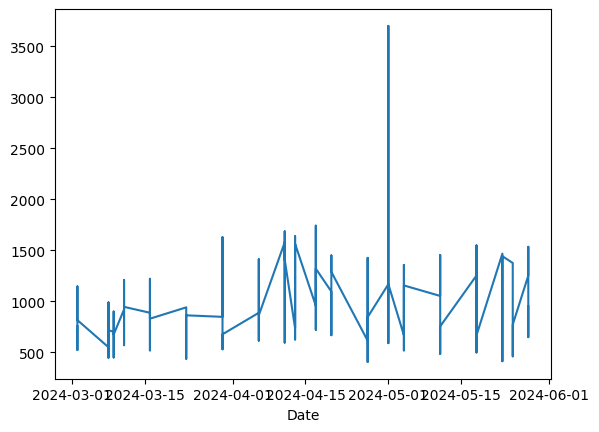

In [ ]:
df_holiday['Total (W)'].plot()
plt.show()

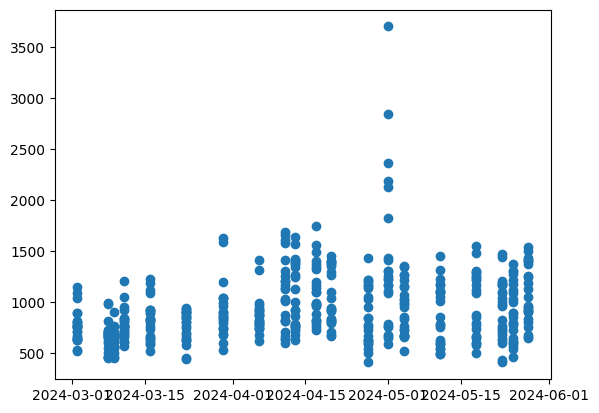

In [ ]:
plt.scatter(df_holiday.index, df_holiday['Total (W)'])
plt.show()

<Axes: xlabel='Date'>

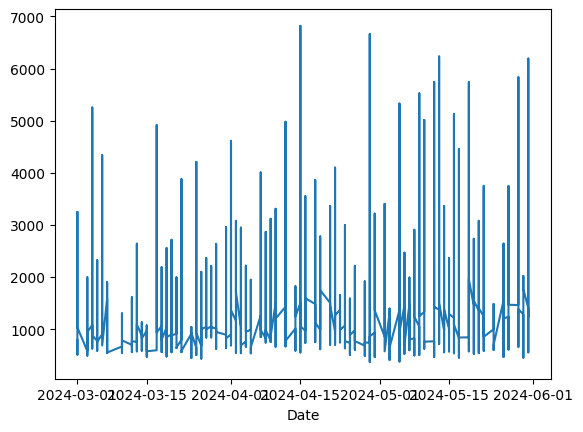

In [ ]:
df_office_day['Total (W)'].plot()

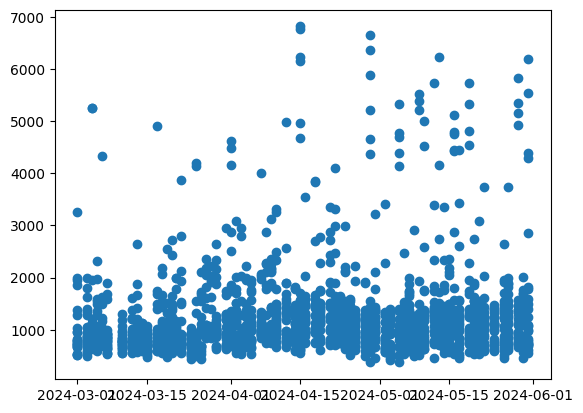

In [ ]:
plt.scatter(df_office_day.index, df_office_day['Total (W)'])
plt.show()

In [ ]:
print(df_holiday['Total (W)'].mean())
print(df_office_day['Total (W)'].mean())

919.8145833333333
1244.8622685185185


**Drop Unnecessary columns** \
We are going to forecast total load based only on the previous values of total load. So, we wiil keep only the 'Total (W)' column.

In [ ]:
df_office_day = pd.DataFrame(df_office_day['Total (W)'])
df_office_day

,Total (W)
Date,
2024-03-01,792.0
2024-03-01,733.0
2024-03-01,706.0
2024-03-01,684.0
2024-03-01,784.0
...,...
2024-05-31,1070.0
2024-05-31,689.0
2024-05-31,718.0


In [ ]:
df_holiday = pd.DataFrame(df_holiday['Total (W)'])
df_holiday

,Total (W)
Date,
2024-03-02,755.0
2024-03-02,620.0
2024-03-02,800.0
2024-03-02,801.0
2024-03-02,710.0
...,...
2024-05-28,1368.0
2024-05-28,1533.0
2024-05-28,899.0


**Scaling**

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_office_day = scaler.fit_transform(df_office_day)
df_office_day = pd.DataFrame(df_office_day, columns=['Total (W)'])
df_office_day

,Total (W)
0,-0.869397
1,-0.887700
2,-0.896076
3,-0.902901
4,-0.871878
...,...
1723,-0.783155
1724,-0.901349
1725,-0.892353
1726,-0.927098


# Separate train and test data

In [ ]:
training_data_len = int(len(df_office_day)*0.6)
validation_data_len = int(len(df_office_day)*0.2)
print(training_data_len)
print(validation_data_len)

train_data = df_office_day[:training_data_len]
validation_data = df_office_day[training_data_len:training_data_len+validation_data_len]
test_data = df_office_day[training_data_len+validation_data_len:]


print(train_data.shape, validation_data.shape, test_data.shape)

1036
345
(1036, 1) (345, 1) (347, 1)


In [ ]:
print(train_data['Total (W)'].mean())
print(validation_data['Total (W)'].mean())
print(test_data['Total (W)'].mean())

-0.7493731183819596
-0.7102825041643906
-0.6863299910733004


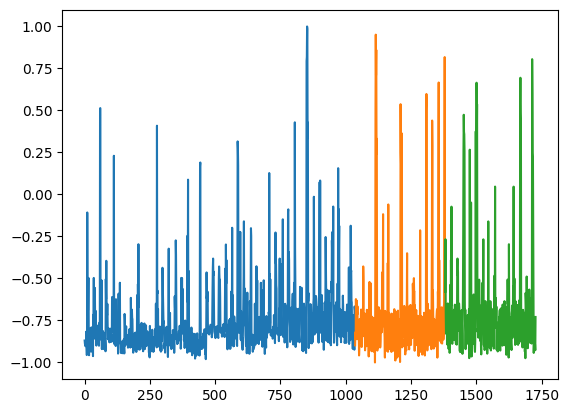

In [ ]:
plt.plot(train_data['Total (W)'])
plt.plot(validation_data['Total (W)'])
plt.plot(test_data['Total (W)'])
plt.show()

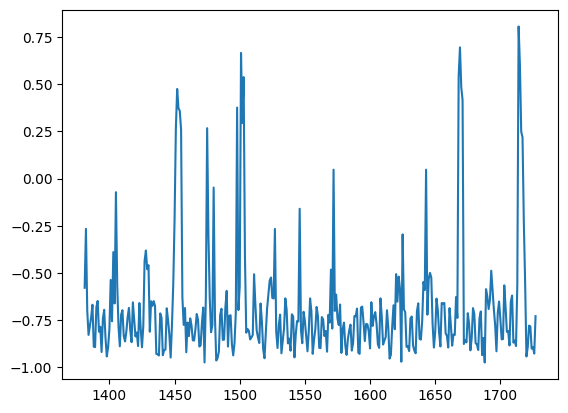

In [ ]:
plt.plot(test_data['Total (W)'])
plt.show()

In [ ]:
dataset_train = train_data['Total (W)'].values
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape


(1036, 1)

In [ ]:
dataset_validation = validation_data['Total (W)'].values
dataset_validation = np.reshape(dataset_validation, (-1, 1))
dataset_validation.shape

(345, 1)

In [ ]:
dataset_test = test_data['Total (W)'].values
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(347, 1)

**Create Sequences**

In [ ]:
scaled_train, scaled_validation, scaled_test = dataset_train, dataset_validation, dataset_test

In [ ]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((1012, 24, 1), (1012, 24, 1))

In [ ]:
X_validation, y_validation = [], []
for i in range(len(scaled_validation)-sequence_length):
  X_validation.append(scaled_validation[i:i+sequence_length])
  y_validation.append(scaled_validation[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_validation, y_validation = np.array(X_validation), np.array(y_validation)

X_validation.shape, y_validation.shape

((321, 24, 1), (321, 24, 1))

In [ ]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
  # y_test.append(scaled_test[i+sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test.shape, y_test.shape

((323, 24, 1), (323, 24, 1))

**Convert to Tensors**

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)
print(X_validation.shape, y_validation.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


torch.Size([1012, 24, 1]) torch.Size([1012, 24, 1])
torch.Size([321, 24, 1]) torch.Size([321, 24, 1])
torch.Size([323, 24, 1]) torch.Size([323, 24, 1])


# Create Model

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, drop_out=0.0):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=drop_out)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out)
    return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
input_size = 1
num_layers = 3
hidden_size = 69
output_size = 1
drop_out = 0.42281
learning_rate = 0.008212

model = LSTM(input_size, hidden_size, num_layers, drop_out).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')

# optimizer = torch.optim.Adam(model.parameters(), lr=0.00314)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00314)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00314)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.00314)

print(model)

LSTM(
  (lstm): LSTM(1, 69, num_layers=3, batch_first=True, dropout=0.42281)
  (fc): Linear(in_features=69, out_features=1, bias=True)
)


**Torch Dataloader**

In [ ]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [ ]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([32, 24, 1]), y shape: torch.Size([32, 24, 1])


# Train the Model

In [ ]:
num_epochs = 29
train_loss_hist =[]
validation_loss_hist =[]
train_mape_hist = []
validation_mape_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss_train = 0.0
	total_mape_train = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		# predictions = predictions[:, -1, :]
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss_train += loss.item()
		total_mape_train += torch.mean(torch.abs((predictions[:, -1, :] - batch_y[:, -1, :])/(batch_y[:, -1, :]+1e-8)))*100.0

	# Calculate average training loss and accuracy
	average_loss_train = total_loss_train / len(train_loader)
	train_loss_hist.append(average_loss_train)
	average_mape_train = total_mape_train / len(train_loader)
	train_mape_hist.append(average_mape_train)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_loss_validation = 0.0
		total_mape_validation = 0.0

		for batch_X_validation, batch_y_validation in validation_loader:
			batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
			predictions_validation = model(batch_X_validation).to(device)
			# predictions_validation = predictions_validation[:, -1, :]
			validation_loss = loss_fn(predictions_validation, batch_y_validation)

			total_mape_validation += torch.mean(torch.abs((predictions_validation[:, -1, :] - batch_y_validation[:, -1, :])/(batch_y_validation[:, -1, :]+1e-8)))*100.0
			total_loss_validation += validation_loss.item()

		# Calculate average test loss and accuracy
		average_loss_validation = total_loss_validation / len(validation_loader)
		validation_loss_hist.append(average_loss_validation)
		average_mape_validation = total_mape_validation / len(validation_loader)
		validation_mape_hist.append(average_mape_validation)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss_train:.4f}, Validation Loss: {average_loss_validation:.4f}')


Epoch [10/29] - Training Loss: 0.0329, Validation Loss: 0.0700
Epoch [20/29] - Training Loss: 0.0285, Validation Loss: 0.0668


In [ ]:
for i in range(len(train_mape_hist)):
  if (i+1) % 10 == 0:
    print(f'Epoch {i+1} - Training MAPE: {train_mape_hist[i]:.2f}, Validation MAPE: {validation_mape_hist[i]:.2f}')

Epoch 10 - Training MAPE: 29.78, Validation MAPE: 38.92
Epoch 20 - Training MAPE: 26.07, Validation MAPE: 36.10


In [ ]:
print(f'Training MAPE: {train_mape_hist[-1]:.2f}, Validation MAPE: {validation_mape_hist[-1]:.2f}')

Training MAPE: 22.34, Validation MAPE: 34.53


In [ ]:
train_mapes = []
for i in range(len(train_mape_hist)):
  train_mapes.append(train_mape_hist[i].item())

validation_mapes = []
for i in range(len(validation_mape_hist)):
  validation_mapes.append(validation_mape_hist[i].item())

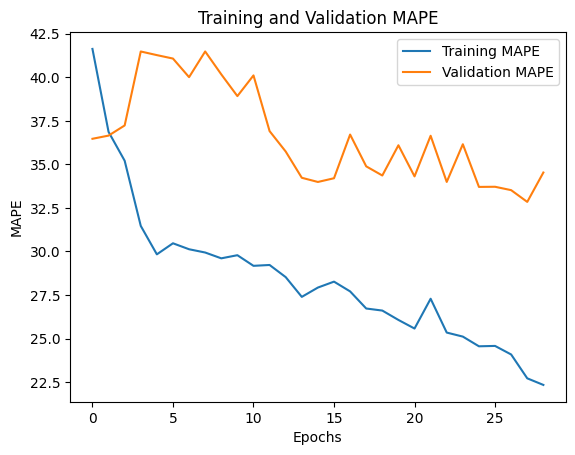

In [ ]:
plt.plot(train_mapes, label="Training MAPE")
plt.plot(validation_mapes, label="Validation MAPE")
plt.title("Training and Validation MAPE")
plt.xlabel("Epochs")
plt.ylabel("MAPE")
plt.legend()
plt.show()

# Evaluate on Test Data

In [ ]:
actuals_test = np.array([])
predictions_test = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        predictions = model(batch_X_test)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_test = np.append(predictions_test, predictions[:, -1])

        actuals =  batch_y_test.to('cpu').numpy().squeeze()
        actuals_test = np.append(actuals_test, actuals[:, -1])


In [ ]:
# MAPE on test data
relative_abs_error = abs((actuals_test-predictions_test)/actuals_test)
print(f"MAPE on test data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on test data = 43.93


In [ ]:
actuals_test = np.expand_dims(actuals_test, axis=1)
actuals_test_original = scaler.inverse_transform(actuals_test)

predictions_test = np.expand_dims(predictions_test, axis=1)
predictions_test_original = scaler.inverse_transform(predictions_test)

pd.DataFrame({'Predicted Power':predictions_test_original.squeeze(), 'Actual Power': actuals_test_original.squeeze()})

,Predicted Power,Actual Power
0,2395.426276,3360.999992
1,2234.810256,1770.000010
2,2009.612090,1062.000023
3,1031.783822,729.000064
4,849.053286,1268.999972
...,...,...
318,1116.999792,1069.999972
319,1082.339303,688.999935
320,900.395754,717.999918
321,932.205911,606.000058


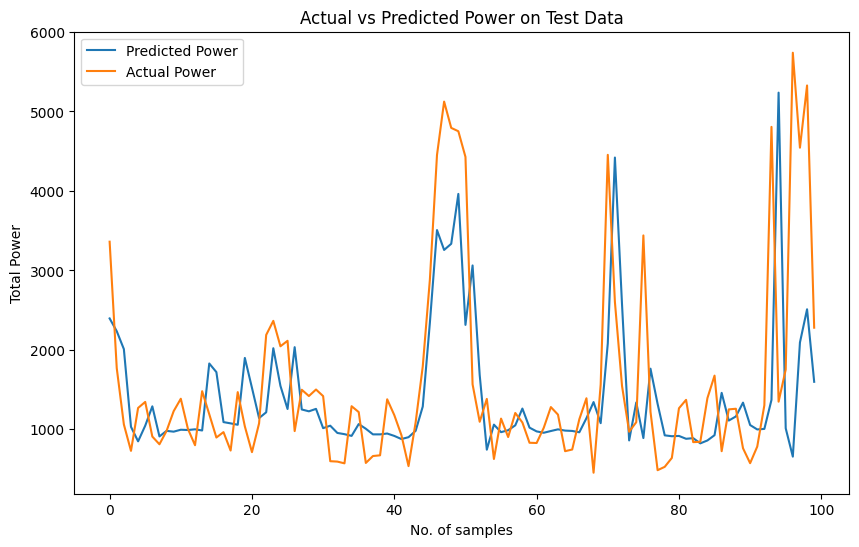

In [ ]:
# plot actual vs predicted powers on first test data
plt.figure(figsize=(10, 6))
plt.plot(predictions_test_original[:100], label='Predicted Power')
plt.plot(actuals_test_original[:100], label='Actual Power')
plt.title('Actual vs Predicted Power on Test Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-evaluate on Training Data

In [ ]:
actuals_train = np.array([])
predictions_train = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_train, batch_y_train in train_loader:
        batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device)
        predictions = model(batch_X_train)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_train = np.append(predictions_train, predictions[:, -1])

        actuals =  batch_y_train.to('cpu').numpy().squeeze()
        actuals_train = np.append(actuals_train, actuals[:, -1])


In [ ]:
# MAPE on training data
relative_abs_error = abs((actuals_train-predictions_train)/actuals_train)
print(f"MAPE on train data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on train data = 19.76


In [ ]:
actuals_train = np.expand_dims(actuals_train, axis=1)
actuals_train_original = scaler.inverse_transform(actuals_train)

predictions_train = np.expand_dims(predictions_train, axis=1)
predictions_train_original = scaler.inverse_transform(predictions_train)

pd.DataFrame({'Predicted Power':predictions_train_original.squeeze(), 'Actual Power': actuals_train_original.squeeze()})

,Predicted Power,Actual Power
0,1897.416060,1359.999990
1,1667.041089,1805.000002
2,1494.837085,3079.000019
3,831.279593,708.000030
4,905.487347,1019.999956
...,...,...
1007,802.817974,843.000055
1008,865.633049,943.000088
1009,842.030539,623.000021
1010,973.854947,1101.000086


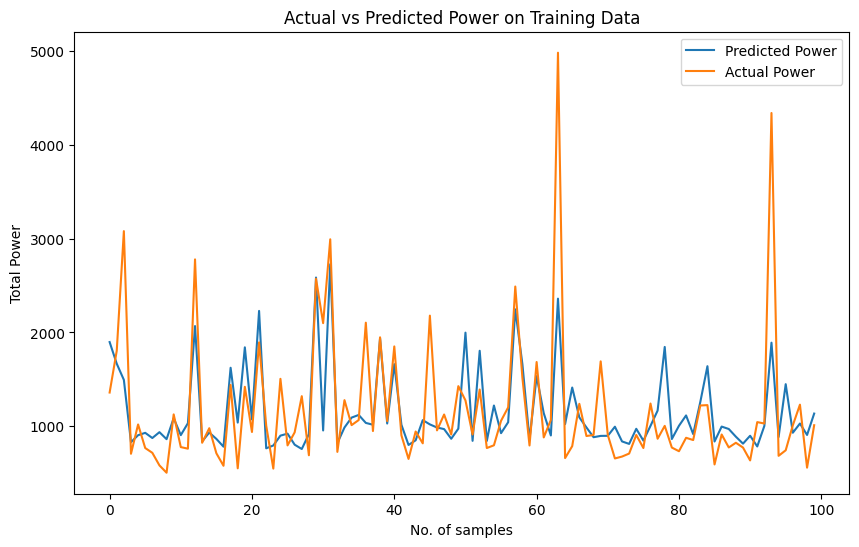

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_train_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_train_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on Training Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-Evaluate on Validation Data

In [ ]:
actuals_validation = np.array([])
predictions_validation = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_validation, batch_y_validation in validation_loader:
        batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
        predictions = model(batch_X_validation)
        predictions = predictions.to('cpu').detach().numpy()[:, :]
        predictions_validation = np.append(predictions_validation, predictions[:, -1])

        actuals =  batch_y_validation.to('cpu').numpy()[:, :]
        actuals_validation = np.append(actuals_validation, actuals[:, -1])


In [ ]:
# MAPE on validation dataset
relative_abs_error = abs((actuals_validation-predictions_validation)/actuals_validation)
print(f"MAPE on validation data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on validation data = 31.27


In [ ]:
actuals_validation = np.expand_dims(actuals_validation, axis=1)
actuals_validation_original = scaler.inverse_transform(actuals_validation)

predictions_validation = np.expand_dims(predictions_validation, axis=1)
predictions_validation_original = scaler.inverse_transform(predictions_validation)

pd.DataFrame({'Predicted Power':predictions_validation_original.squeeze(), 'Actual Power': actuals_validation_original.squeeze()})

,Predicted Power,Actual Power
0,1016.615680,676.000043
1,1005.659341,668.000094
2,1061.327933,875.999916
3,1194.299199,1062.000023
4,1349.777417,1194.000044
...,...,...
316,1085.016520,1461.000089
317,1983.934900,1236.999985
318,1817.636374,4153.000018
319,2668.182991,6231.000080


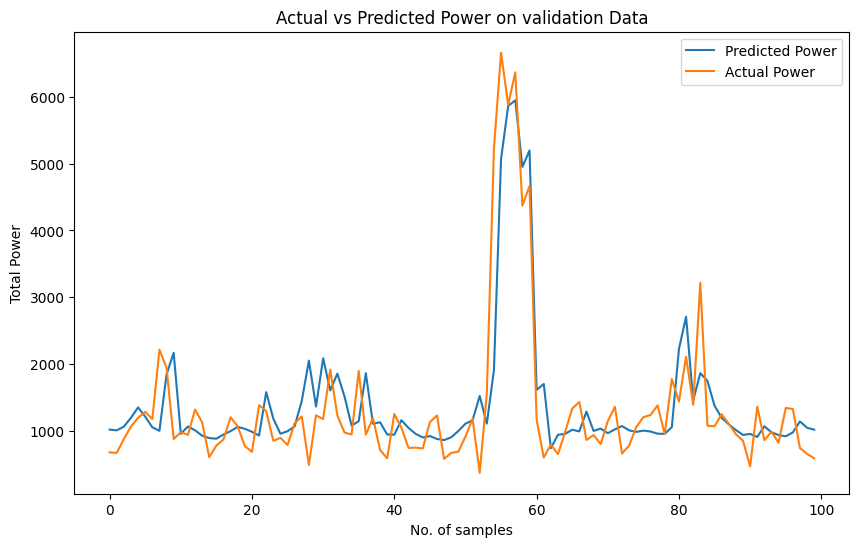

In [ ]:
# plot on first 100 validation data
plt.figure(figsize=(10, 6))
plt.plot(predictions_validation_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_validation_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on validation Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()